# Imports

In [33]:
import os
import errno

import pandas as pd
import numpy as np

from helper_functions import (variables_amount_deviation, perform_feauture_selection, 
                              cross_validation_bagging, make_confusion_matrix, make_precision_recall_curves)

from pyod.models import pca, cblof, knn, iforest, copod, lof

# Data loading, preprocessing and feature engineering

In [5]:
# df = pd.read_csv('data/sim0.csv', delimiter=';', low_memory=False)
df = pd.read_csv('data/sim1.csv', delimiter=';', low_memory=False)
# df = pd.read_csv('data/sim3.csv', delimiter=';', low_memory=False)
# df = pd.read_csv('data/sim4.csv', delimiter=';', low_memory=False)
# df = pd.read_csv('data/sim5.csv', delimiter=';', low_memory=False)


# Strip hour since all are the same
df['date'] = pd.to_datetime(df.date).dt.date

# Drop columns with unique values
df.drop(columns=['currency', 'location'], inplace=True)

df.head()

,account_from,account_to,sender,receiver,amount,channel,date,flag,transaction_type,transaction_id
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,8774.32,Paym,2021-01-01,transaction,2.2,35655
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,56547.95,LINK,2021-01-01,transaction,2.2,35656
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,17.10,C&CCC,2021-01-01,transaction,0.1,35657
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2000.00,CASH,2021-01-01,fraud,bribe,35658
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,91.15,FPS,2021-01-01,transaction,0.2,35659


In [6]:
# Add type of transaction markers (B2B-P2P-B2P-P2B)

# Create markers
p2p_marker = (df.sender.str.lower().str.contains('individual') & 
              df.receiver.str.lower().str.contains('individual'))
p2b_marker = (df.sender.str.lower().str.contains('individual') & 
              df.receiver.str.lower().str.contains('business'))
b2b_marker = (df.sender.str.lower().str.contains('business') & 
              df.receiver.str.lower().str.contains('business'))
b2p_marker = (df.sender.str.lower().str.contains('business') & 
              df.receiver.str.lower().str.contains('individual'))

# Create Series object and add it to dataframe
transaction_mode = pd.Series(['']*df.shape[0])
transaction_mode[p2p_marker] = 'P2P'
transaction_mode[p2b_marker] = 'P2B'
transaction_mode[b2b_marker] = 'B2B'
transaction_mode[b2p_marker] = 'B2P'
df['transaction_mode'] = transaction_mode

# Add Sender and Receiver Marker
df['sender_type'] = df.transaction_mode.astype(str).str[0]
df['receiver_type'] = df.transaction_mode.astype(str).str[2]

# Manipulate date 
df['day_of_week'] = pd.to_datetime(df.date).dt.dayofweek
df['month'] = pd.to_datetime(df.date).dt.month
df.drop(columns=['date'], inplace=True)

# Transform amount using logarithm
# df['amount'] = df.amount.transform(np.log)

df.head()

,account_from,account_to,sender,receiver,amount,channel,flag,transaction_type,transaction_id,transaction_mode,sender_type,receiver_type,day_of_week,month
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,8774.32,Paym,transaction,2.2,35655,B2B,B,B,4,1
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,56547.95,LINK,transaction,2.2,35656,B2B,B,B,4,1
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,17.10,C&CCC,transaction,0.1,35657,B2B,B,B,4,1
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2000.00,CASH,fraud,bribe,35658,B2P,B,P,4,1
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,91.15,FPS,transaction,0.2,35659,P2P,P,P,4,1


In [9]:
# Get indicators of sender and receiver for both the deviation of the transaction
# According to certain groups

df = variables_amount_deviation(df, ['month'], ['sender_monthly', 'receiver_monthly'])
df = variables_amount_deviation(df, ['channel'], ['sender_medium', 'receiver_medium'])
df = variables_amount_deviation(df, ['account_from'], ['sender_account_from', 'receiver_account_from'])
df = variables_amount_deviation(df, ['account_to'], ['sender_account_to', 'receiver_account_to'])
df = variables_amount_deviation(df, ['channel', 'month'], ['sender_medium_month', 'receiver_medium_month'])
df = variables_amount_deviation(df, ['month', 'day_of_week'], ['sender_month_dayofweek', 'receiver_month_dayofweek'])
df = variables_amount_deviation(df, ['channel', 'day_of_week'], ['sender_medium_dayofweek', 'receiver_medium_dayofweek'])
df = variables_amount_deviation(df, ['account_from', 'channel'], ['sender_account_from_medium', 'receiver_account_from_medium'])
df = variables_amount_deviation(df, ['account_from', 'month'], ['sender_account_from_month', 'receiver_account_from_month'])
df = variables_amount_deviation(df, ['account_from', 'day_of_week'], ['sender_account_from_day_of_week', 
                                                                      'receiver_account_from_day_of_week'])
df = variables_amount_deviation(df, ['account_to', 'channel'], ['sender_fieldo_medium', 'receiver_fieldo_medium'])
df = variables_amount_deviation(df, ['account_to', 'month'], ['sender_fieldo_month', 'receiver_fieldo_month'])
df = variables_amount_deviation(df, ['account_to', 'day_of_week'], ['sender_fieldo_day_of_week', 'receiver_fieldo_day_of_week'])
# df = variables_amount_deviation(df, ['channel', 'month', 'day_of_week'], ['sender_medium_month_dayofweek',
#                                                                          'receiver_medium_month_dayofweek'])
# df = variables_amount_deviation(df, ['account_from', 'month', 'channel'], ['sender_account_from_month_medium', 
#                                                                           'receiver_account_from_month_medium'])
# df = variables_amount_deviation(df, ['account_from', 'month','day_of_week'], ['sender_account_from_month_day_of_week', 
#                                                                               'receiver_account_from_month_day_of_week'])
# df = variables_amount_deviation(df, ['account_from', 'channel', 'day_of_week'], ['sender_account_from_medium_day_of_week', 
#                                                                                 'receiver_account_from_medium_day_of_week'])
# df = variables_amount_deviation(df, ['account_from', 'month', 'channel', 'day_of_week'], ['sender_account_from_medium_day_of_week_month', 
#                                                                                          'sender_account_from_medium_day_of_week_month'])
# df = variables_amount_deviation(df, ['account_to', 'month', 'channel'], ['sender_account_to_month_medium', 
#                                                                     'receiver_account_to_month_medium'])
# df = variables_amount_deviation(df, ['account_to', 'month','day_of_week'], ['sender_account_to_month_day_of_week', 
#                                                                         'receiver_account_to_month_day_of_week'])
# df = variables_amount_deviation(df, ['account_to', 'channel', 'day_of_week'], ['sender_fieldo_medium_day_of_week', 
#                                                                           'receiver_fieldo_medium_day_of_week'])
# df = variables_amount_deviation(df, ['account_to', 'month', 'channel', 'day_of_week'], ['sender_account_to_medium_day_of_week_month', 
#                                                                                    'sender_account_to_medium_day_of_week_month'])

df.head()

,account_from,account_to,sender,receiver,amount,channel,flag,transaction_type,transaction_id,transaction_mode,...,sender_account_from_month,receiver_account_from_month,sender_account_from_day_of_week,receiver_account_from_day_of_week,sender_fieldo_medium,receiver_fieldo_medium,sender_fieldo_month,receiver_fieldo_month,sender_fieldo_day_of_week,receiver_fieldo_day_of_week
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,8774.32,Paym,transaction,2.2,35655,B2B,...,-9.597737,-11.969154,-13.227427,-18.135013,-17.938438,-15.687191,-15.377369,-13.349430,-18.893403,-18.399891
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,56547.95,LINK,transaction,2.2,35656,B2B,...,-68.997358,-84.418756,-92.842182,-125.626755,-120.741416,-122.707446,-107.958335,-93.566421,-130.743352,-126.959052
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,17.10,C&CCC,transaction,0.1,35657,B2B,...,1.290603,1.311334,1.366480,1.568929,1.391109,1.381105,1.593330,1.354871,1.609427,1.499716
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2000.00,CASH,fraud,bribe,35658,B2P,...,-1.174847,inf,-1.938023,inf,-313.777038,-313.777038,-0.002608,-80.044010,-0.880423,-40.709931
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,91.15,FPS,transaction,0.2,35659,P2P,...,-3.193896,-3.215190,-1.979993,-2.268911,-3.494436,-2.134434,-2.948617,-3.032655,-2.847416,-2.587624


In [12]:
# Field A Scaling

# Segment types of senders
df_p = df[p2p_marker | p2b_marker]
df_b = df[b2p_marker | b2b_marker]

# Get Median 
median_p = np.median(df_p.amount)
median_b = np.median(df_b.amount)

# Median Deviation 
median_desviation_p = df_p.amount.sub(median_p)
median_desviation_b = df_b.amount.sub(median_b)

# Median Absolute Deviation
abs_median_desviation_p = np.median(median_desviation_p.abs())
abs_median_desviation_b = np.median(median_desviation_b.abs())

# Scaling 
df_p_scaled = median_desviation_p/abs_median_desviation_p
df_b_scaled = median_desviation_b/abs_median_desviation_b

# Assign values
df.loc[(p2p_marker | p2b_marker), 'amount'] = df_p_scaled
df.loc[(b2p_marker | b2b_marker), 'amount'] = df_b_scaled

df = df.replace([np.inf, -np.inf, np.nan], 0)
df.head()

,account_from,account_to,sender,receiver,amount,channel,flag,transaction_type,transaction_id,transaction_mode,...,sender_account_from_month,receiver_account_from_month,sender_account_from_day_of_week,receiver_account_from_day_of_week,sender_fieldo_medium,receiver_fieldo_medium,sender_fieldo_month,receiver_fieldo_month,sender_fieldo_day_of_week,receiver_fieldo_day_of_week
0,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,15.353341,Paym,transaction,2.2,35655,B2B,...,-9.597737,-11.969154,-13.227427,-18.135013,-17.938438,-15.687191,-15.377369,-13.349430,-18.893403,-18.399891
1,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,106.878088,LINK,transaction,2.2,35656,B2B,...,-68.997358,-84.418756,-92.842182,-125.626755,-120.741416,-122.707446,-107.958335,-93.566421,-130.743352,-126.959052
2,Account 113,Account 115,Fraudulent_businesses 4,Fraudulent_businesses 6,-1.423746,C&CCC,transaction,0.1,35657,B2B,...,1.290603,1.311334,1.366480,1.568929,1.391109,1.381105,1.593330,1.354871,1.609427,1.499716
3,Account 113,Account 184,Fraudulent_businesses 4,Individuals 65,2.375095,CASH,fraud,bribe,35658,B2P,...,-1.174847,0.000000,-1.938023,0.000000,-313.777038,-313.777038,-0.002608,-80.044010,-0.880423,-40.709931
4,Account 124,Account 170,Fraudulent_individuals 5,Individuals 51,2.821119,FPS,transaction,0.2,35659,P2P,...,-3.193896,-3.215190,-1.979993,-2.268911,-3.494436,-2.134434,-2.948617,-3.032655,-2.847416,-2.587624


# Feature Selection

In [13]:
df_numerical = df.select_dtypes('float64')
df_numerical.columns

Index(['amount', 'sender_monthly', 'receiver_monthly', 'sender_medium',
       'receiver_medium', 'sender_account_from', 'receiver_account_from',
       'sender_account_to', 'receiver_account_to', 'sender_medium_month',
       'receiver_medium_month', 'sender_month_dayofweek',
       'receiver_month_dayofweek', 'sender_medium_dayofweek',
       'receiver_medium_dayofweek', 'sender_account_from_medium',
       'receiver_account_from_medium', 'sender_account_from_month',
       'receiver_account_from_month', 'sender_account_from_day_of_week',
       'receiver_account_from_day_of_week', 'sender_fieldo_medium',
       'receiver_fieldo_medium', 'sender_fieldo_month',
       'receiver_fieldo_month', 'sender_fieldo_day_of_week',
       'receiver_fieldo_day_of_week'],
      dtype='object')

In [17]:
df_feature_selection = perform_feauture_selection(df_numerical)

df_feature_selection.head()

,sender_account_from_month,sender_account_from_day_of_week,sender_account_from_medium,sender_account_from,receiver_account_from_medium,receiver_account_from_month,receiver_account_from,sender_fieldo_month,sender_fieldo_medium,sender_month_dayofweek,sender_fieldo_day_of_week,sender_account_to,receiver_medium_dayofweek,receiver_fieldo_day_of_week,receiver_monthly,receiver_medium
0,-9.597737,-13.227427,-11.782456,-14.689864,-12.687862,-11.969154,-17.140438,-15.377369,-17.938438,-7.248907,-18.893403,-17.787941,-18.407777,-18.399891,-23.931194,-29.288211
1,-68.997358,-92.842182,-89.087636,-102.620567,-115.676076,-84.418756,-118.950005,-107.958335,-120.741416,-53.138207,-130.743352,-123.024314,-151.098590,-126.959052,-160.552191,-176.559433
2,1.290603,1.366480,1.496006,1.428411,1.403420,1.311334,1.521924,1.593330,1.391109,1.162903,1.609427,1.502577,1.282630,1.499716,1.112331,1.018115
3,-1.174847,-1.938023,-313.777038,-2.221255,-313.777038,0.000000,0.000000,-0.002608,-313.777038,-0.741785,-0.880423,-0.554187,-138.324649,-40.709931,-55.190903,-117.799224
4,-3.193896,-1.979993,-1.397853,-2.572842,-1.697315,-3.215190,-2.522378,-2.948617,-3.494436,-2.624242,-2.847416,-2.842383,-1.136685,-2.587624,-1.264779,-2.401076


# Stacking and Representation Learning

In [21]:
# Global Variable
CONTAMINATION = 0.01
df_scores = pd.DataFrame()

# Intialize, fit, and use the different classifiers and store
# their decision scores in a df

# Principal Component Analysis
pca_od = pca.PCA(contamination=CONTAMINATION, n_components=3)
pca_od.fit(df_feature_selection)
df_scores['PCA-1'] = pca_od.decision_scores_

pca_od = pca.PCA(contamination=CONTAMINATION, n_components=5)
pca_od.fit(df_feature_selection)
df_scores['PCA-2'] = pca_od.decision_scores_

pca_od = pca.PCA(contamination=CONTAMINATION, n_components=7)
pca_od.fit(df_feature_selection)
df_scores['PCA-3'] = pca_od.decision_scores_
print('PCA: done')

# Cluster Based Local Outlier Factor
cblof_od = cblof.CBLOF(contamination=CONTAMINATION, n_jobs=-1, n_clusters=2)
cblof_od.fit(df_feature_selection)
df_scores['CBLOF-1'] = cblof_od.decision_scores_

cblof_od = cblof.CBLOF(contamination=CONTAMINATION, n_jobs=-1, n_clusters=4)
cblof_od.fit(df_feature_selection)
df_scores['CBLOF-2'] = cblof_od.decision_scores_

cblof_od = cblof.CBLOF(contamination=CONTAMINATION, n_jobs=-1, n_clusters=6)
cblof_od.fit(df_feature_selection)
df_scores['CBLOF-3'] = cblof_od.decision_scores_
print('CLBOF: done')

# K-Nearest Neighbors
knn_od = knn.KNN(contamination=CONTAMINATION, n_neighbors=3, n_jobs=-1)
knn_od.fit(df_feature_selection)
df_scores['KNN-1'] = knn_od.decision_scores_

knn_od = knn.KNN(contamination=CONTAMINATION, n_neighbors=6, n_jobs=-1)
knn_od.fit(df_feature_selection)
df_scores['KNN-2'] = knn_od.decision_scores_

knn_od = knn.KNN(contamination=CONTAMINATION, n_neighbors=9, n_jobs=-1)
knn_od.fit(df_feature_selection)
df_scores['KNN-3'] = knn_od.decision_scores_
print('KNN: done')


df_scores.index = df_feature_selection.index
df_scores = df_scores.fillna(0)
df_scores.head()

PCA: done
CLBOF: done
KNN: done


,PCA-1,PCA-2,PCA-3,CBLOF-1,CBLOF-2,CBLOF-3,KNN-1,KNN-2,KNN-3
0,18.481453,119.386002,366.554680,54.739261,55.873707,61.177696,14.948688,15.233348,16.196157
1,111.373665,642.023032,1938.743860,459.368206,460.526449,466.160765,76.886840,87.153843,97.786787
2,17.634627,96.853919,296.331191,20.345609,19.268507,12.241723,0.254770,0.324230,0.340322
3,174.070141,981.584543,2914.342719,569.516518,570.248552,573.273251,297.471089,333.863711,398.132402
4,16.014578,93.459162,288.434097,13.048987,12.700170,7.033169,1.960902,2.285423,2.340201


# Second Feature Selection

## Only Decision Score

In [22]:
df_scores_feature_selection = perform_feauture_selection(df_scores)

df_scores_feature_selection.head()

,KNN-1,KNN-2,PCA-1,KNN-3,CBLOF-1,CBLOF-2
0,14.948688,15.233348,18.481453,16.196157,54.739261,55.873707
1,76.886840,87.153843,111.373665,97.786787,459.368206,460.526449
2,0.254770,0.324230,17.634627,0.340322,20.345609,19.268507
3,297.471089,333.863711,174.070141,398.132402,569.516518,570.248552
4,1.960902,2.285423,16.014578,2.340201,13.048987,12.700170


## Both Features and Decision Scores

In [23]:
df_joint = df_feature_selection.join(df_scores, how='outer')

df_joint_feature_selection = perform_feauture_selection(df_joint)
df_joint_feature_selection.head()

,sender_account_from_month,sender_account_from_day_of_week,sender_account_from_medium,sender_account_from,receiver_account_from_month,receiver_account_from_medium,sender_fieldo_day_of_week,sender_month_dayofweek,sender_fieldo_medium,sender_fieldo_month,receiver_account_from,receiver_medium_dayofweek,receiver_fieldo_day_of_week,sender_account_to,receiver_monthly
0,-9.597737,-13.227427,-11.782456,-14.689864,-11.969154,-12.687862,-18.893403,-7.248907,-17.938438,-15.377369,-17.140438,-18.407777,-18.399891,-17.787941,-23.931194
1,-68.997358,-92.842182,-89.087636,-102.620567,-84.418756,-115.676076,-130.743352,-53.138207,-120.741416,-107.958335,-118.950005,-151.098590,-126.959052,-123.024314,-160.552191
2,1.290603,1.366480,1.496006,1.428411,1.311334,1.403420,1.609427,1.162903,1.391109,1.593330,1.521924,1.282630,1.499716,1.502577,1.112331
3,-1.174847,-1.938023,-313.777038,-2.221255,0.000000,-313.777038,-0.880423,-0.741785,-313.777038,-0.002608,0.000000,-138.324649,-40.709931,-0.554187,-55.190903
4,-3.193896,-1.979993,-1.397853,-2.572842,-3.215190,-1.697315,-2.847416,-2.624242,-3.494436,-2.948617,-2.522378,-1.136685,-2.587624,-2.842383,-1.264779


## Combine Decision Scores with Old Features

In [24]:
df_joint_old_features = df_feature_selection.join(df_scores_feature_selection, how='outer')

df_joint_old_features.head()

,sender_account_from_month,sender_account_from_day_of_week,sender_account_from_medium,sender_account_from,receiver_account_from_medium,receiver_account_from_month,receiver_account_from,sender_fieldo_month,sender_fieldo_medium,sender_month_dayofweek,...,receiver_medium_dayofweek,receiver_fieldo_day_of_week,receiver_monthly,receiver_medium,KNN-1,KNN-2,PCA-1,KNN-3,CBLOF-1,CBLOF-2
0,-9.597737,-13.227427,-11.782456,-14.689864,-12.687862,-11.969154,-17.140438,-15.377369,-17.938438,-7.248907,...,-18.407777,-18.399891,-23.931194,-29.288211,14.948688,15.233348,18.481453,16.196157,54.739261,55.873707
1,-68.997358,-92.842182,-89.087636,-102.620567,-115.676076,-84.418756,-118.950005,-107.958335,-120.741416,-53.138207,...,-151.098590,-126.959052,-160.552191,-176.559433,76.886840,87.153843,111.373665,97.786787,459.368206,460.526449
2,1.290603,1.366480,1.496006,1.428411,1.403420,1.311334,1.521924,1.593330,1.391109,1.162903,...,1.282630,1.499716,1.112331,1.018115,0.254770,0.324230,17.634627,0.340322,20.345609,19.268507
3,-1.174847,-1.938023,-313.777038,-2.221255,-313.777038,0.000000,0.000000,-0.002608,-313.777038,-0.741785,...,-138.324649,-40.709931,-55.190903,-117.799224,297.471089,333.863711,174.070141,398.132402,569.516518,570.248552
4,-3.193896,-1.979993,-1.397853,-2.572842,-1.697315,-3.215190,-2.522378,-2.948617,-3.494436,-2.624242,...,-1.136685,-2.587624,-1.264779,-2.401076,1.960902,2.285423,16.014578,2.340201,13.048987,12.700170


## Combine Filtered Decision Scores with Old Features

In [25]:
df_joint_old_new_features = perform_feauture_selection(df_joint_old_features)

df_joint_old_new_features.head()

,sender_account_from_month,sender_account_from_day_of_week,sender_account_from_medium,sender_account_from,sender_fieldo_month,sender_fieldo_medium,sender_month_dayofweek,receiver_account_from_medium,receiver_account_from_month,receiver_fieldo_day_of_week,sender_fieldo_day_of_week,receiver_medium_dayofweek,sender_account_to,receiver_monthly
0,-9.597737,-13.227427,-11.782456,-14.689864,-15.377369,-17.938438,-7.248907,-12.687862,-11.969154,-18.399891,-18.893403,-18.407777,-17.787941,-23.931194
1,-68.997358,-92.842182,-89.087636,-102.620567,-107.958335,-120.741416,-53.138207,-115.676076,-84.418756,-126.959052,-130.743352,-151.098590,-123.024314,-160.552191
2,1.290603,1.366480,1.496006,1.428411,1.593330,1.391109,1.162903,1.403420,1.311334,1.499716,1.609427,1.282630,1.502577,1.112331
3,-1.174847,-1.938023,-313.777038,-2.221255,-0.002608,-313.777038,-0.741785,-313.777038,0.000000,-40.709931,-0.880423,-138.324649,-0.554187,-55.190903
4,-3.193896,-1.979993,-1.397853,-2.572842,-2.948617,-3.494436,-2.624242,-1.697315,-3.215190,-2.587624,-2.847416,-1.136685,-2.842383,-1.264779


# Dataset Checkpoints

In [26]:
# # Create Datasets Folder
# try:
#     os.mkdir('dataset_checkpoints/')
# except OSError as e:
#     if e.errno == errno.EEXIST:
#         print('Directory already exist')
#     else:
#         raise
        
# df_numerical.to_csv('dataset_checkpoints/df_numerical_sim0.csv')
# df_feature_selection.to_csv('dataset_checkpoints/df_feature_selection_sim0.csv')
# df_scores.to_csv('dataset_checkpoints/df_scores_sim0.csv')
# df_feature_selection.to_csv('dataset_checkpoints/df_feature_selection_sim0.csv')

# Experimentation

In [27]:
# Create Directory
root = 'experiments/'

try:
    os.mkdir(root)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

# Create Experiment Directory
experiment = str(input('Type Experiment Name: '))
path = root + experiment
try:
    os.mkdir(path)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

# Create training dictionary
X_dict = {'numerical':df_numerical,
          'first_feature_selection':df_feature_selection,
          'decision_scores':df_scores,
          'decision_scores_feature_selection':df_scores_feature_selection,
          'new_decision_scores_feature_selection': df_joint_old_features,
          'joint_feature_selection': df_joint_feature_selection}

y = pd.get_dummies(df.flag).fraud

Directory already exist
Type Experiment Name: test_bagging
Type Model Name: anything


## Model Initialization

In [62]:
# Model initialization
model_iforest = iforest.IForest(contamination=CONTAMINATION, n_estimators=200, 
                        bootstrap=True, max_features=5, n_jobs=-1, behaviour='new')

model_copod = copod.COPOD(contamination=CONTAMINATION, n_jobs=-1)

lof_od = lof.LOF(contamination=CONTAMINATION)

pca_od = pca.PCA(contamination=CONTAMINATION, n_components=3)

cblof_od = cblof.CBLOF(contamination=CONTAMINATION, n_jobs=-1, n_clusters=7)

# Create Dictionary
model_dict = {'IForest':model_iforest, 'COPOD': model_copod, 'LOF':lof_od, 'PCA':pca_od}

# Define Model Codes
model_codes = 'IFOREST-COPOD-LOF-PCA-CBLOF'

# Define number of splits 
k = 5

# Define Threshold
THRESHOLD = 1 - CONTAMINATION

## Cross-Validation

C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8

Index(['fraud'], dtype='object')


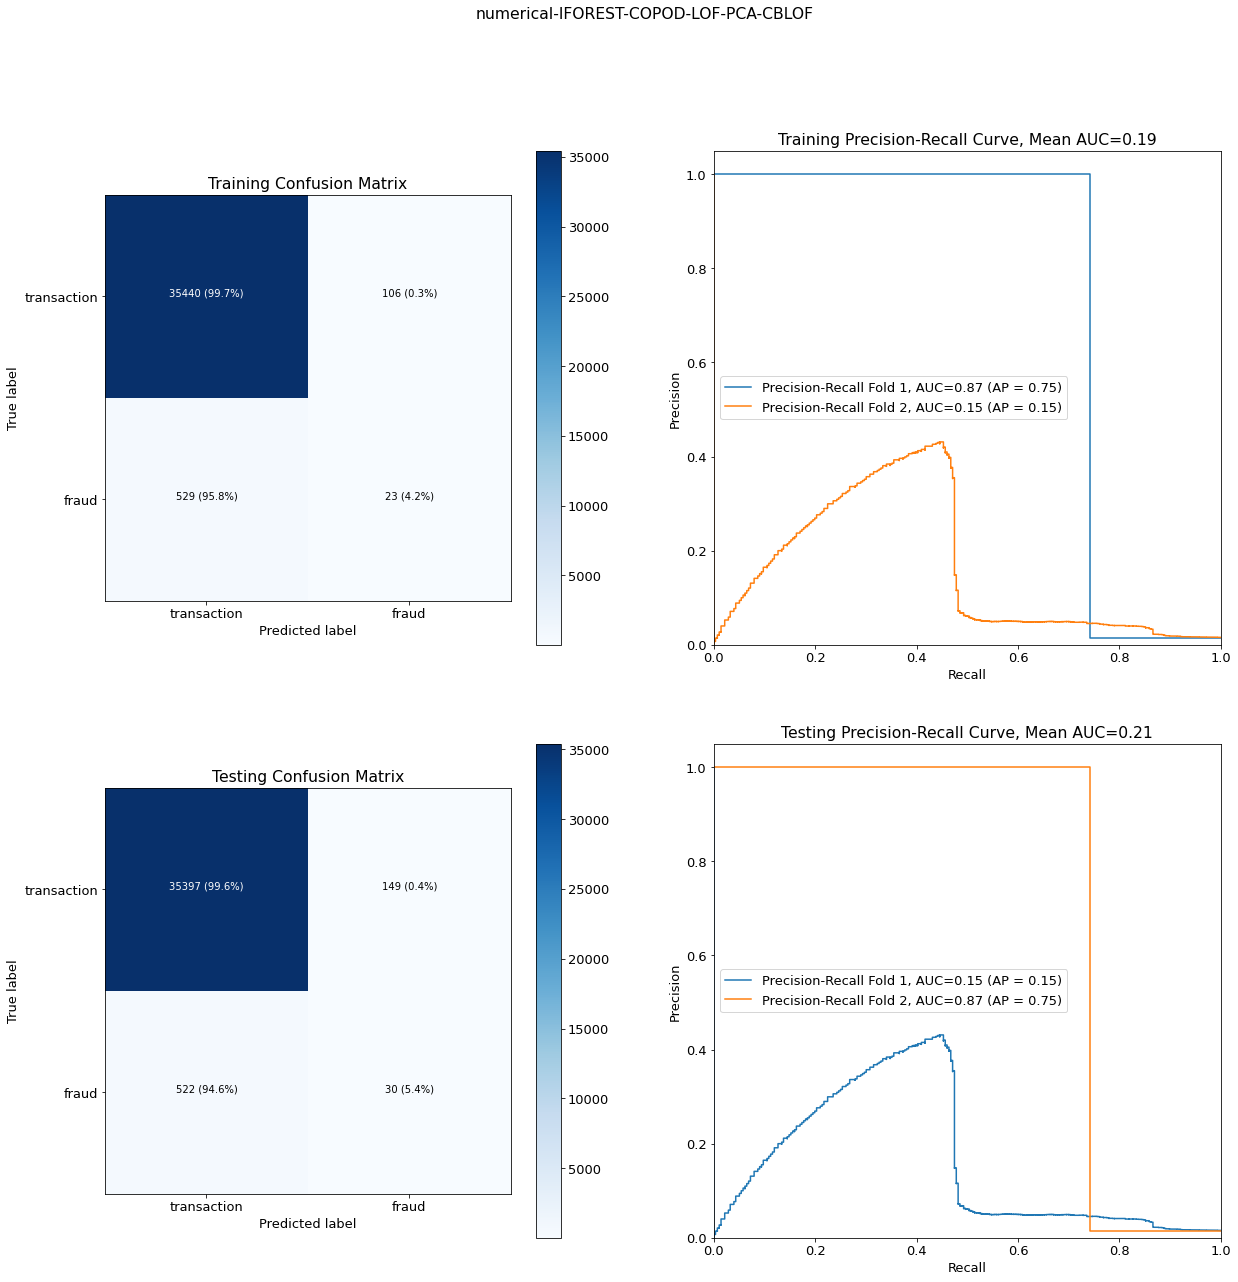

C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8

Index(['fraud'], dtype='object')


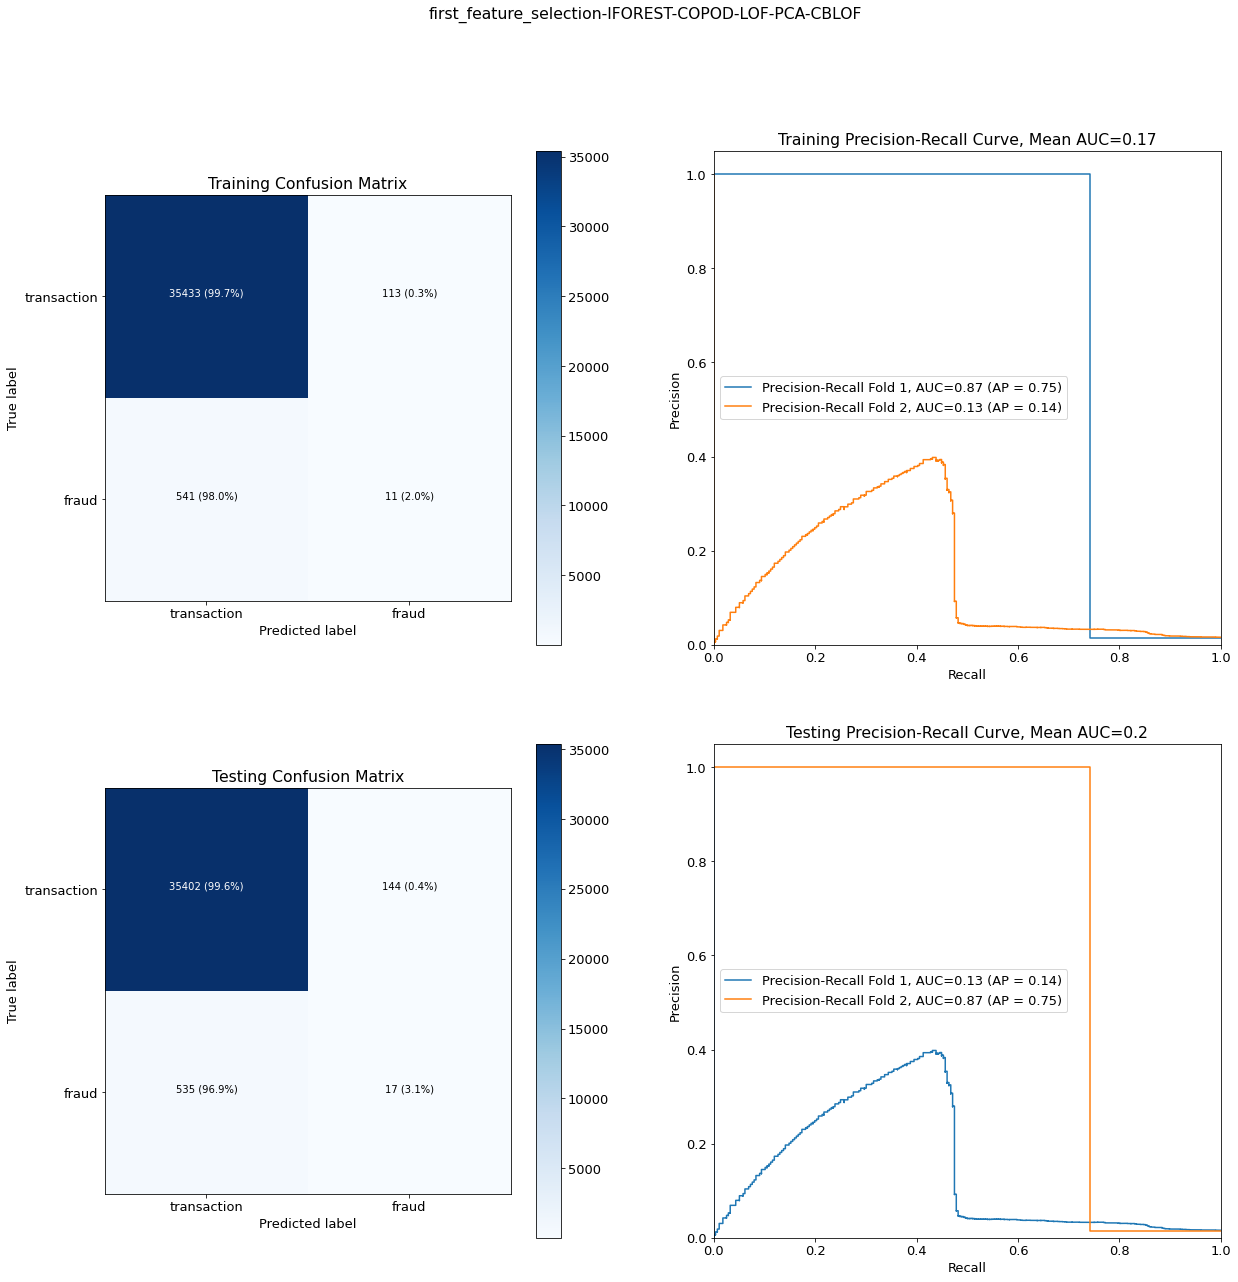

C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8

Index(['fraud'], dtype='object')


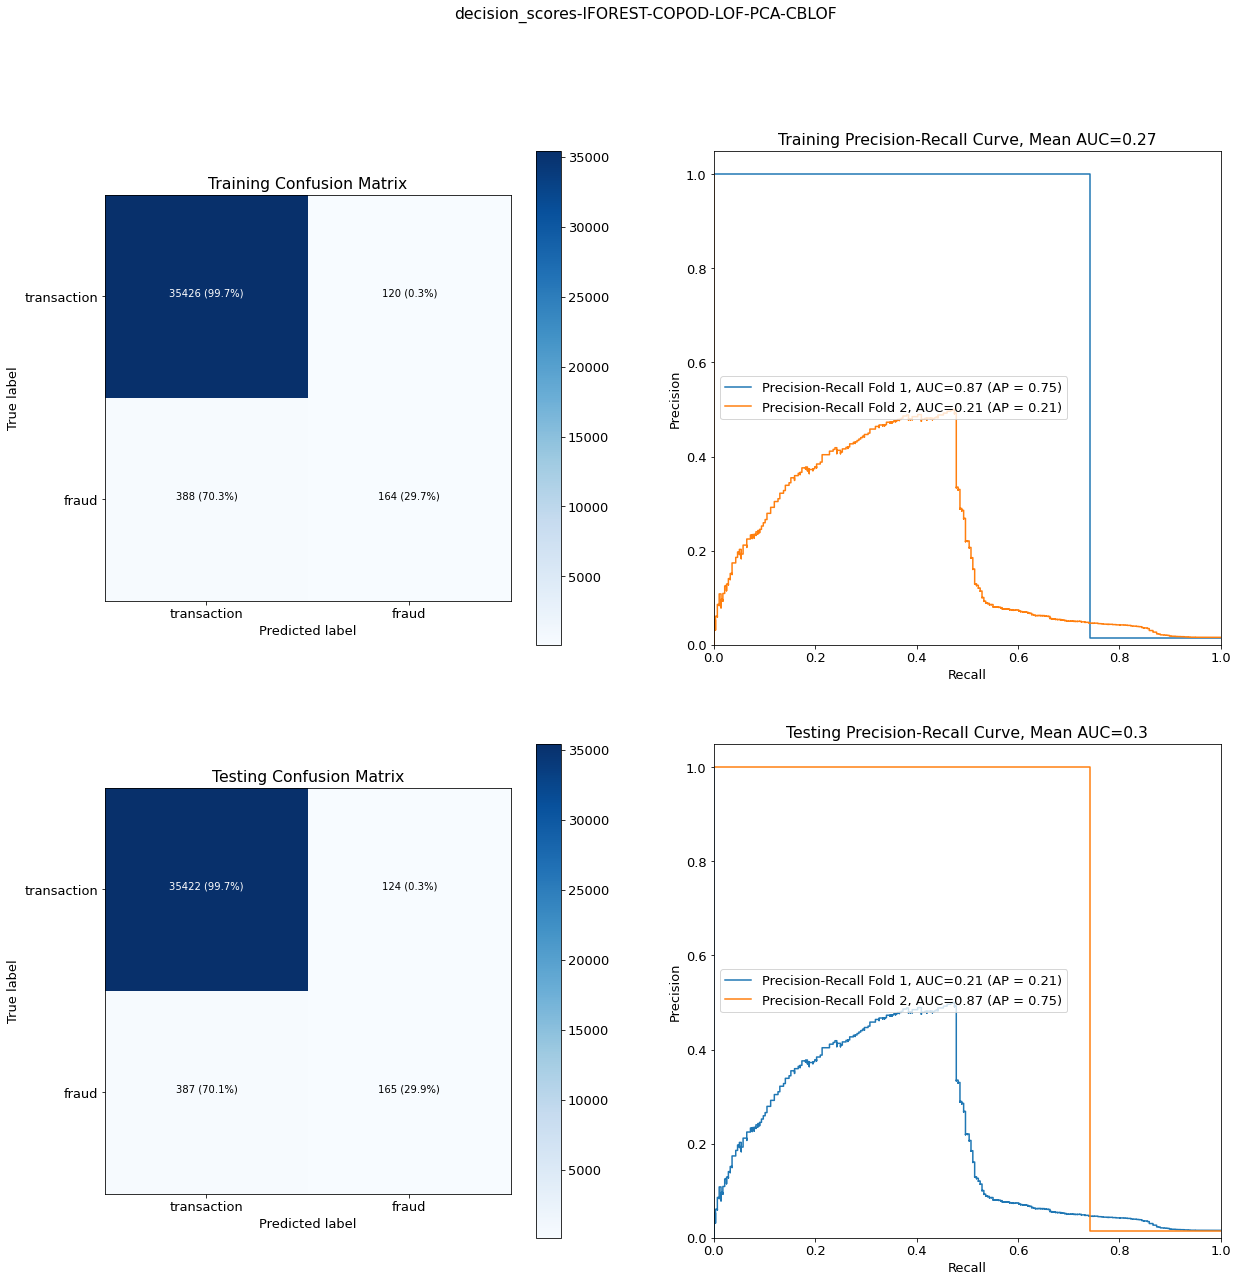

C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6

Index(['fraud'], dtype='object')


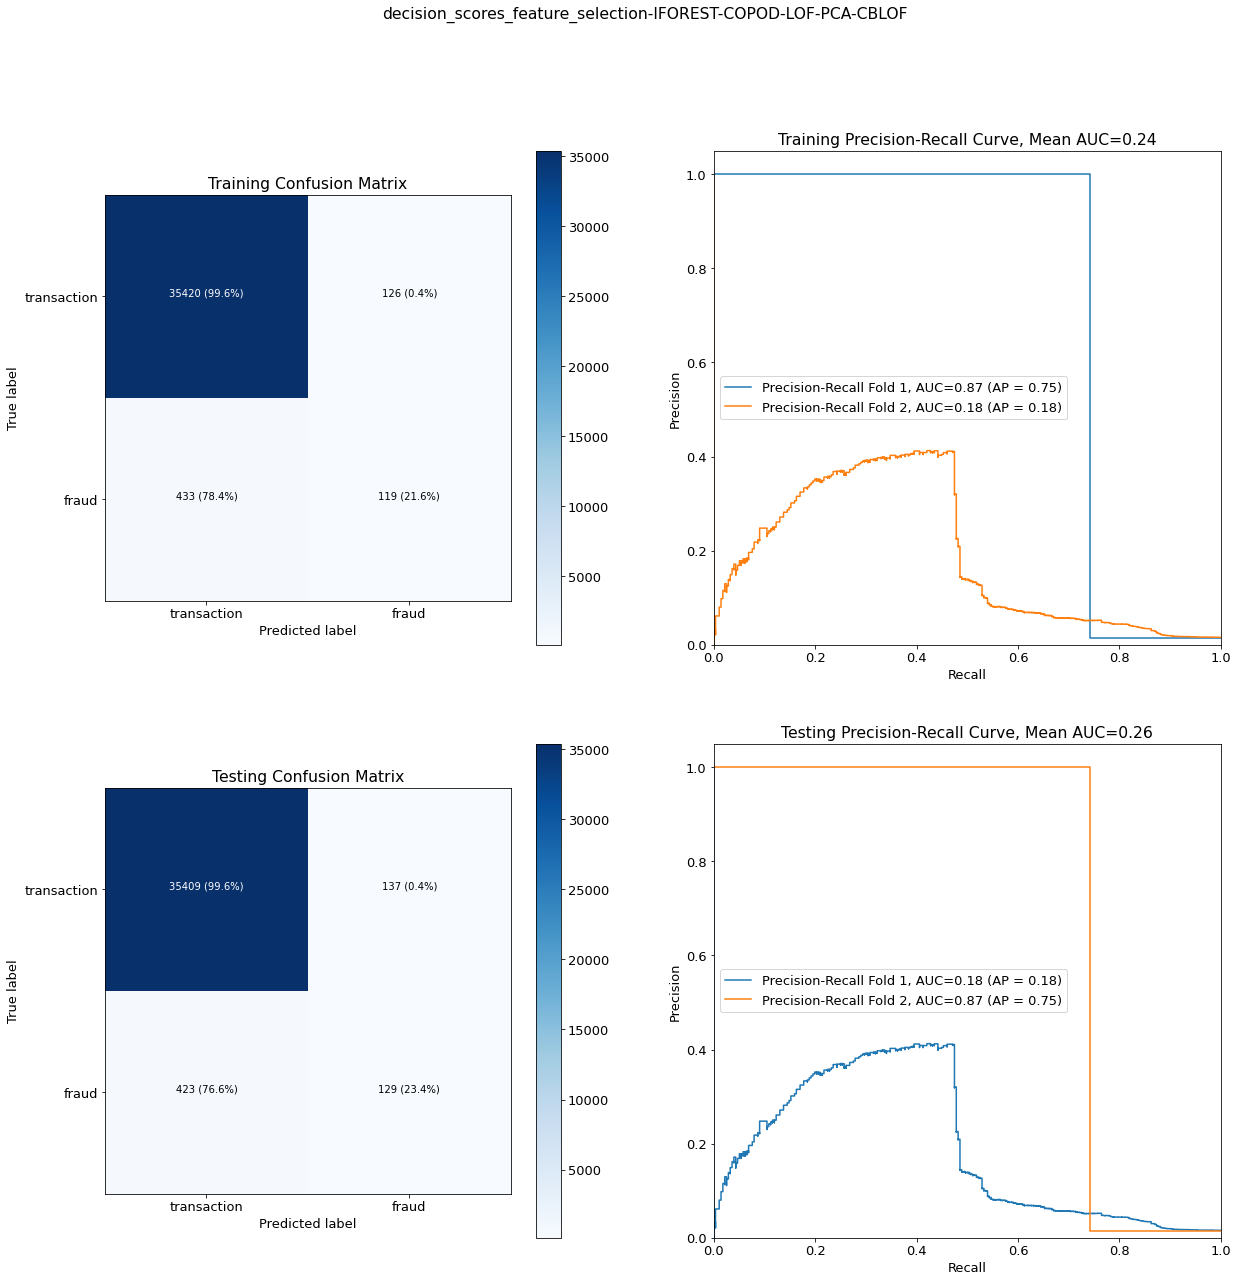

C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8

Index(['fraud'], dtype='object')


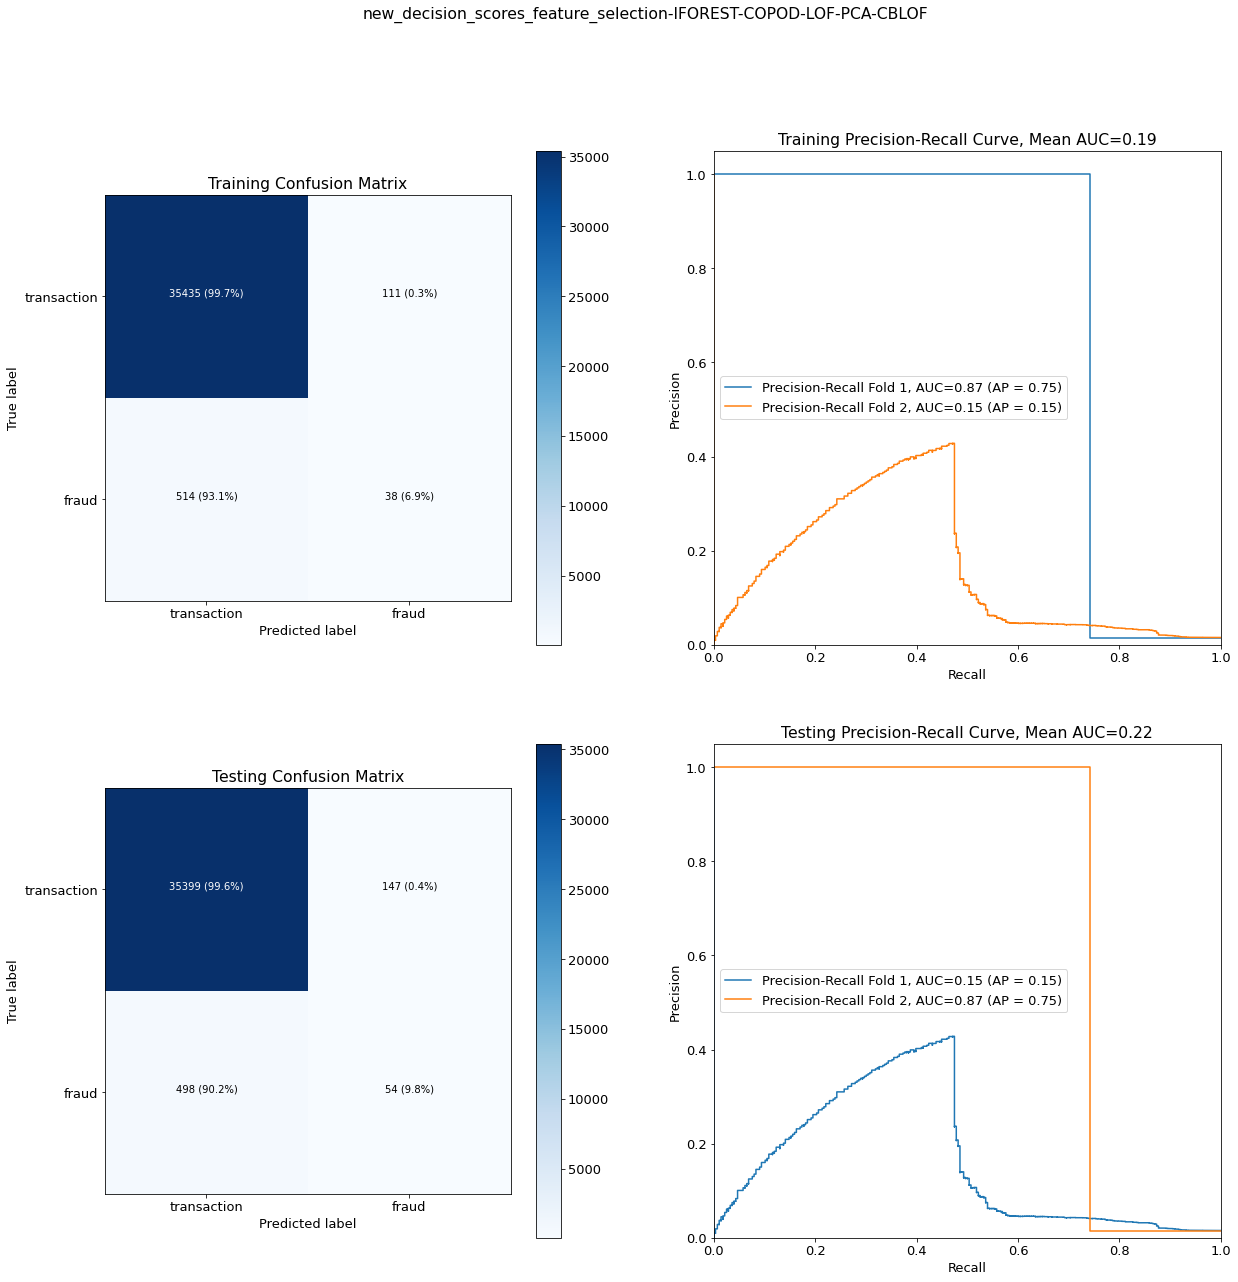

C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8

Index(['fraud'], dtype='object')


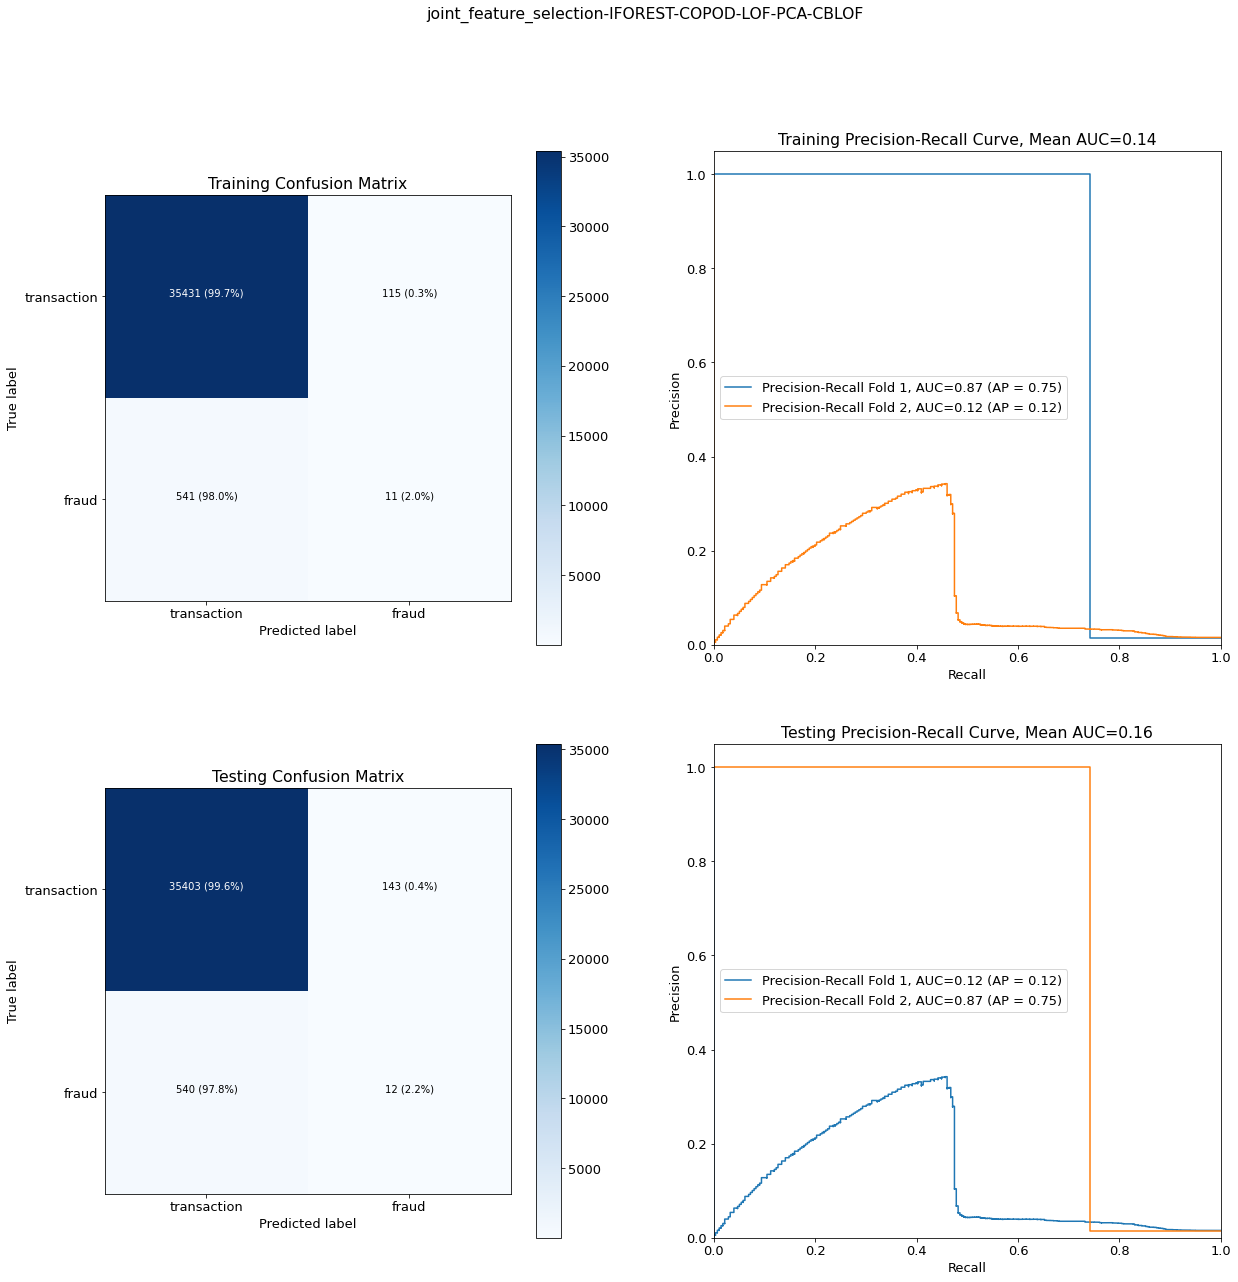

(({'numerical': 0.06784660766961652,
   'first_feature_selection': 0.03273809523809524,
   'decision_scores': 0.38987588500014336,
   'decision_scores_feature_selection': 0.29623743393751345,
   'new_decision_scores_feature_selection': 0.1071224978419141,
   'joint_feature_selection': 0.03254437869822485},
  {'numerical': 0.08645533141210374,
   'first_feature_selection': 0.04965061558206968,
   'decision_scores': 0.3871571072319202,
   'decision_scores_feature_selection': 0.30987020610097216,
   'new_decision_scores_feature_selection': 0.14570630081300814,
   'joint_feature_selection': 0.037500000000000006}),
 ({'numerical': 0.18253968253968253,
   'first_feature_selection': 0.09166666666666666,
   'decision_scores': 0.5721761006289308,
   'decision_scores_feature_selection': 0.47839631586076126,
   'new_decision_scores_feature_selection': 0.24262832180560612,
   'joint_feature_selection': 0.08870967741935484},
  {'numerical': 0.2112676056338028,
   'first_feature_selection': 0.140374

In [73]:
(f1_tuple, precision_tuple, 
     recall_tuple, auc_tuple) = cross_validation_bagging1(model_dict, X_dict, y, k, THRESHOLD, model_codes, path)